注意：在操作此文件之前，你应该已经学习过了train.ipynb文件并训练了自己的检测是否戴口罩的模型

在调用相关模块中的方法之前，我们需要先用import引入对应模块

有时只需要引入模块a下面的b方法，我们就用from a import b

有时又觉得b的名字太长，给起一个名字c方便使用，我们就用from a import b as c

In [1]:
#author: lengkujiaai@126.com

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

一般习惯上将一些常量或全局变量写入配置文件方便以后的修改，或者把常量写在开头，比如下面的model_name、constant_confidence

在后面的函数中使用这些常量时，只需要用关键字global model_name标记一下，就可以在函数中使用这些变量

下面两个是常量，因为他们被赋值后不再改变

1、model_name是前面训练戴口罩检测程序保存的模型，想用哪个模型，就可以在后面改成对应模型的名字

2、constant_confidence的确信度的一个界值，当大于0.5时就认为带了口罩，否则就任务没有戴口罩

In [2]:
model_name = "mask_detector.model"
constant_confidence = 0.5

下面是调用的检测人脸的模型，该模型是前人已经训练好的模型，所以我们不用训练模型，直接调用即可

1、deploy.prototxt是神经网络中网络层数、层间关系、激活函数等相关的配置信息

2、res10_300x300_ssd_iter_140000.caffemodel是别人训练好的模型

3、prototxtPath和weightsPath是对应的文件路径

4、faceNet保存的是网络模型及其权值，方便后面调用

In [3]:
print("[INFO] 加载检测人脸模型...")
prototxtPath = "face_detector/deploy.prototxt"
weightsPath = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] 加载检测人脸模型...


加载我们自己已经训练的检测是否戴口罩的模型

In [4]:
print("[INFO] 加载是否戴口罩的模型...")
maskNet = load_model(model_name)

[INFO] 加载是否戴口罩的模型...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


调用训练好的模型进行检测是否带口罩

In [5]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    global confidence
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()
    faces = []
    locs = []
    preds = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > constant_confidence:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))    
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
                
            faces.append(face)
            locs.append((startX, startY, endX, endY))      
    if len(faces) > 0:
        preds = maskNet.predict(faces)
    return (locs, preds)

In [6]:
from IPython.display import clear_output, Image, display, HTML
import base64
import numpy as np

调用csi相机需要该函数，可以根据需要更改对应参数

In [7]:
def gstreamer_pipeline(capture_width=400, capture_height=400, display_width=400, display_height=400, framerate=30, flip_method=0,):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

在python2中显示视频的方法：

ret, png = cv2.imencode('.png', imageArray)

encoded = base64.b64encode(png)

return Image(data=encoded.decode('ascii'))

因为我们的环境是python3，所以用下面的方法将存储图片的数组转换成图片

In [8]:
def arrayShow(imageArray):#这是在python3中的方法
    ret, png = cv2.imencode('.png', imageArray)
    return Image(data=png)

先定义两个全局变量，方便使用

In [9]:
i = 1
max_frame = 40

重要的事情说三遍，重要的事情说三遍，重要的事情说三遍

注意：max_frame必须设置一个数字作为检测图片的次数，运行够次数后自动退出，不知道就不用改

注意：max_frame必须设置一个数字作为检测图片的次数，运行够次数后自动退出，不知道就不用改

注意：max_frame必须设置一个数字作为检测图片的次数，运行够次数后自动退出，不知道就不用改

我设置的是40，网页显示有点慢，如果连接显示器，在终端操作会快不少

下面定义的方法是通过模型检测是否带口罩

In [10]:
def show_detect(video):
    global i, max_frame
    global faceNet, maskNet
    if i > 1:
        i = 1
    while True:
        i += 1
        if i == max_frame:
            break
        clear_output(wait=True)
        ret,frame = video.read()
        try:
            (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
            for (box, pred) in zip(locs, preds):
                (startX, startY, endX, endY) = box
                (mask, withoutMask) = pred
                label = "mask" if mask > withoutMask else "no mask"
                color = (0, 255, 0) if label == "mask" else (0, 0, 255)
                label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
                cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            img = arrayShow(frame)
            display(img)
        except Exception as e:
            if i >10:
                video.release()
                print('video.release()')
                break
    return 0

下面定义只显示视频，不检测人脸、也不检测是否戴口罩的方法

In [11]:
def show_video(video):
    global i
    if i > 1:
        i = 1
    global max_frame
    while True:
        i += 1
        if i == max_frame:
            break
        clear_output(wait=True)
        ret,frame = video.read()
        try:
            img = arrayShow(frame)
            #img = cv2.resize(img,(224,224))
            display(img)
        except Exception as e:
            print('--error')
            print(e)
            video.release()
    return 0

通过opencv的方法VideoCapture()获取相机的实例，方便对相机进行操作

1、此处为初始化

2、使用完了对应最后的release（）释放

有点像吃饭前去取餐具，吃完饭把餐具送回

In [12]:
video = cv2.VideoCapture(gstreamer_pipeline(flip_method=0), cv2.CAP_GSTREAMER)

让我们调用摄像头试试，这里只是显示摄像头捕获到的图片，并没有做人脸及口罩的检测

在连接显示器，并通过终端调用py脚本执行的速度是很快的，只是在jupyter notebook中速度很慢，有时间再看看有没有调优的方法

其实，有不同的方法可以调用显示摄像头视频，比如opencv的方法就很好用，但是在notebook中不能用cv2.imshow()显示图片，这样就限制了发挥

In [13]:
show_video(video)

--error
OpenCV(4.1.1) /home/nvidia/host/build_opencv/nv_opencv/modules/imgcodecs/src/loadsave.cpp:894: error: (-215:Assertion failed) code in function 'imencode'



0

我们接着调用一下检测人脸和戴口罩模型试试

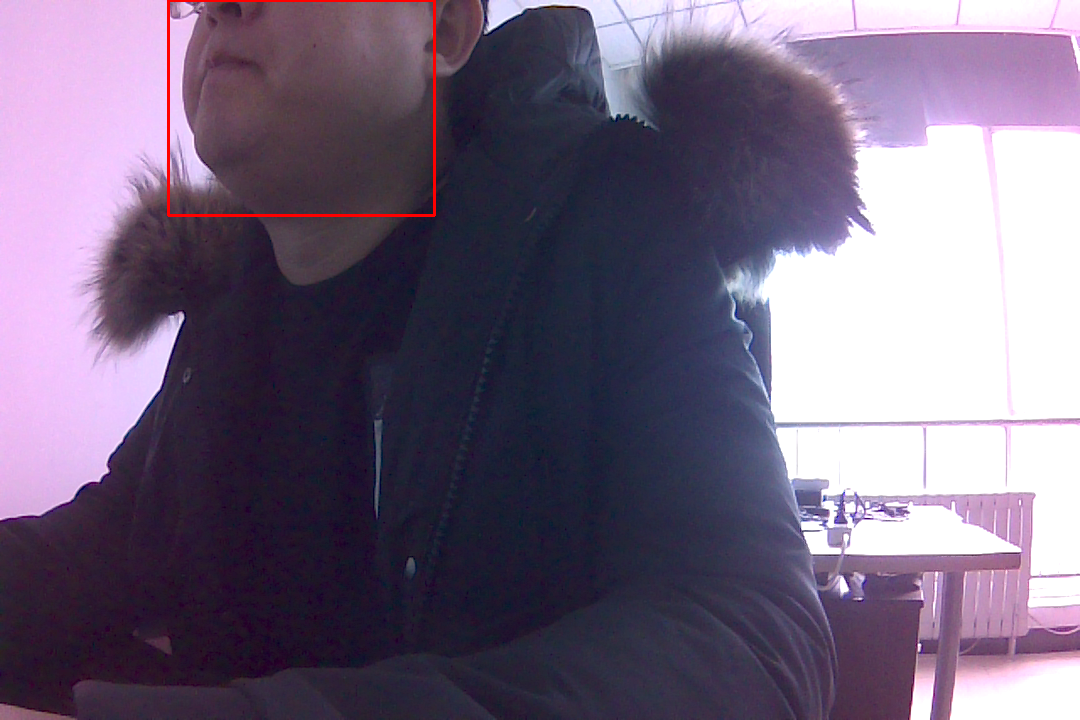

In [ ]:
show_detect(video)

在使用完摄像头显示视频之后，记得一定要用release()释放掉摄像头，否则下次初始化或在别处初始化时可能会失败，而你又找不到原因

所以一定要执行video.release(),这里video是摄像头的实例（也就是对象），对摄像头的操作就是对video的操作

In [14]:
video.release()